In [1]:
import tensorflow as tf
print(tf.__version__)

physical_device = tf.config.experimental.list_physical_devices("GPU")
if len(physical_device) > 0:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
    

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.2.0
GPU name: /device:GPU:0


# Sequence modelling 

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

***
<a id="coding_tutorial_1"></a>
## The IMDb Dataset

#### Load the IMDB review sentiment dataset

In [3]:
# Import imdb

import tensorflow.keras.datasets.imdb as imdb

In [4]:
# Download and assign the data set using load_data()

(x_train, y_train), (x_test, y_test) = imdb.load_data()

#### Inspect the dataset

In [5]:
# Inspect the type of the data

type(x_train)

numpy.ndarray

In [6]:
# Inspect the shape of the data

x_train.shape

(25000,)

In [8]:
# Display the first dataset element input
# Notice encoding

x_train[0]

In [9]:
# Display the first dataset element output

y_train[0]

1

#### Load dataset with different options

In [ ]:
# Load the dataset with defaults

imdb.load_data(path='imdb.npz', index_from=3)
# ~/.keras/dataset/

In [ ]:
# Limit the vocabulary to the top 500 words using num_words

imdb.load_data(num_words=1000)

In [ ]:
# Ignore the top 10 most frequent words using skip_top

imdb.load_data(skip_top=10, num_words=1000, oov_char=1)

In [ ]:
# Limit the sequence lengths to 500 using maxlen

imdb.load_data(maxlen=500)

In [ ]:
 # Use '1' as the character that indicates the start of a sequence

imdb.load_data(start_char=1)

#### Explore the dataset word index

In [13]:
# Load the imdb word index using get_word_index()

imdb_word_index = imdb.get_word_index()
type(imdb_word_index)

dict

In [14]:
# View the word index as a dictionary,
# accounting for index_from.
index_from = 3
imdb_word_index = {key: value+index_from for key, value in imdb_word_index.items()}


In [17]:
# Retrieve a specific word's index

print(imdb_word_index['simpsonian'])
print(imdb_word_index['the'])

52256
4


In [19]:
# View an input sentence

inv_imdb_word_index = {value: key for key, value in imdb_word_index.items()}
[inv_imdb_word_index[index] for index in x_train[0] if index > index_from]

['this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being',
 'there',
 'robert',
 "redford's",
 'is',
 'an',
 'amazing',
 'actor',
 'and',
 'now',
 'the',
 'same',
 'being',
 'director',
 "norman's",
 'father',
 'came',
 'from',
 'the',
 'same',
 'scottish',
 'island',
 'as',
 'myself',
 'so',
 'i',
 'loved',
 'the',
 'fact',
 'there',
 'was',
 'a',
 'real',
 'connection',
 'with',
 'this',
 'film',
 'the',
 'witty',
 'remarks',
 'throughout',
 'the',
 'film',
 'were',
 'great',
 'it',
 'was',
 'just',
 'brilliant',
 'so',
 'much',
 'that',
 'i',
 'bought',
 'the',
 'film',
 'as',
 'soon',
 'as',
 'it',
 'was',
 'released',
 'for',
 'retail',
 'and',
 'would',
 'recommend',
 'it',
 'to',
 'everyone',
 'to',
 'watch',
 'and',
 'the',
 'fly',
 'fishing',
 'was',
 'amazing',
 'really',
 'cried',
 'at',
 'the',


In [20]:
# Get the sentiment value

y_train[0]

1

---
<a id="coding_tutorial_2"></a>
## Padding and Masking Sequence Data

In [5]:
# Load the imdb data set

import tensorflow.keras.datasets.imdb as imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data()

#### Preprocess the data with padding

In [6]:
# Inspect the input data shape

x_train.shape

(25000,)

In [7]:
# Pad the inputs to the maximum length using maxlen

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x_train = pad_sequences(x_train, maxlen=300, padding='post',
                               truncating='pre')

In [8]:
# Inspect the output data shape

padded_x_train.shape

(25000, 300)

#### Create a Masking layer

In [9]:
# Import numpy 

import numpy as np

In [10]:
# Masking expects to see (batch, sequence, features)
# Create a dummy feature dimension using expand_dims

padded_x_train = np.expand_dims(padded_x_train, -1)

In [11]:
# Create a Masking layer 

tf_x_train = tf.convert_to_tensor(padded_x_train, dtype='float32')
masking_layers = tf.keras.layers.Masking(mask_value=0.0)

In [12]:
# Pass tf_x_train to it

masked_x_train = masking_layers(tf_x_train)

In [ ]:
# Look at the dataset



In [13]:
# Look at the ._keras_mask for the dataset

masked_x_train._keras_mask

<tf.Tensor: shape=(25000, 300), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

***
<a id="coding_tutorial_3"></a>
## The Embedding layer

#### Create and apply an `Embedding` layer

In [14]:
# Create an embedding layer using layers.Embedding
# Specify input_dim, output_dim, input_length

embedding_layer = tf.keras.layers.Embedding(input_dim=501, output_dim=16)

In [15]:
# Inspect an Embedding layer output for a fixed input
# Expects an input of shape (batch, sequence, feature)

seqence_of_indices = tf.constant([[[0], [1], [5], [500]]])
seqence_of_embedding = embedding_layer(seqence_of_indices)
seqence_of_embedding

<tf.Tensor: shape=(1, 4, 1, 16), dtype=float32, numpy=
array([[[[ 0.03354928,  0.00076849,  0.0066208 ,  0.01060613,
           0.01662448, -0.01394513, -0.04532696,  0.02149541,
          -0.00614049, -0.01424807, -0.00154511, -0.01761713,
          -0.02740656,  0.03552982, -0.03833022,  0.035209  ]],

        [[ 0.02208546, -0.01720606,  0.01742666, -0.0358839 ,
          -0.0104836 , -0.00241286, -0.02735755,  0.03188213,
          -0.04244701, -0.02574586, -0.02915294,  0.02970984,
          -0.00821976, -0.0086738 , -0.04849621,  0.00902013]],

        [[-0.01442904,  0.03904558,  0.02718968,  0.03311957,
           0.02739936,  0.02636807,  0.02524351, -0.03775314,
           0.0329015 ,  0.03222292, -0.00394505, -0.04070092,
           0.04296884,  0.00116267, -0.04751734,  0.02969759]],

        [[-0.00755042,  0.0314315 ,  0.03320343, -0.01508024,
           0.02785159, -0.02739222,  0.01412041, -0.00229288,
           0.04560442, -0.01889353, -0.02915194, -0.00392262,
      

In [16]:
# Inspect the Embedding layer weights using get_weights()

embedding_layer.get_weights()[0]

array([[ 0.03354928,  0.00076849,  0.0066208 , ...,  0.03552982,
        -0.03833022,  0.035209  ],
       [ 0.02208546, -0.01720606,  0.01742666, ..., -0.0086738 ,
        -0.04849621,  0.00902013],
       [-0.04473851,  0.01766708, -0.00144988, ...,  0.00235633,
        -0.01911149, -0.0356804 ],
       ...,
       [-0.0247816 ,  0.0471988 ,  0.0159544 , ..., -0.02767139,
         0.03151212,  0.01524068],
       [-0.02255721,  0.01992584,  0.01003071, ..., -0.04766105,
         0.02929589,  0.02511961],
       [-0.00755042,  0.0314315 ,  0.03320343, ..., -0.0162072 ,
         0.0012516 ,  0.00189058]], dtype=float32)

In [17]:
# Get the embedding for the 14th index

embedding_layer.get_weights()[0][14, :]

array([-0.02577893,  0.03003291, -0.02787782,  0.04254908, -0.03065762,
       -0.01017006,  0.00174468, -0.0293784 , -0.03608911,  0.01840034,
       -0.01575677,  0.00142679, -0.00270439, -0.00741921, -0.01869041,
       -0.00435681], dtype=float32)

#### Create and apply an `Embedding` layer that uses `mask_zero=True`

In [18]:
# Create a layer that uses the mask_zero kwarg

masking_embedding_layer = tf.keras.layers.Embedding(input_dim=501,
                                                    output_dim=16,
                                                    mask_zero=True)

In [19]:
# Apply this layer to the sequence and see the _keras_mask property

masked_seqence_of_embedding = masking_embedding_layer(seqence_of_indices)
masked_seqence_of_embedding._keras_mask

<tf.Tensor: shape=(1, 4, 1), dtype=bool, numpy=
array([[[False],
        [ True],
        [ True],
        [ True]]])>

---
<a id="coding_tutorial_4"></a>
## The Embedding Projector

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Load and preprocess the IMDb data

In [20]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [21]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

In [22]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [23]:
# Get the word index

imdb_word_index = get_imdb_word_index()

In [24]:
# Swap the keys and values of the word index

inv_imdb_word_index = {value: key for key, value in imdb_word_index.items()}

In [25]:
# View the first dataset example sentence

[inv_imdb_word_index[index] for index in x_train[100] if index > 2]

['i',
 'am',
 'a',
 'great',
 'fan',
 'of',
 'david',
 'lynch',
 'and',
 'have',
 'everything',
 'that',
 "he's",
 'made',
 'on',
 'dvd',
 'except',
 'for',
 'hotel',
 'room',
 'the',
 '2',
 'hour',
 'twin',
 'peaks',
 'movie',
 'so',
 'when',
 'i',
 'found',
 'out',
 'about',
 'this',
 'i',
 'immediately',
 'grabbed',
 'it',
 'and',
 'and',
 'what',
 'is',
 'this',
 "it's",
 'a',
 'bunch',
 'of',
 'drawn',
 'black',
 'and',
 'white',
 'cartoons',
 'that',
 'are',
 'loud',
 'and',
 'foul',
 'mouthed',
 'and',
 'unfunny',
 'maybe',
 'i',
 "don't",
 'know',
 "what's",
 'good',
 'but',
 'maybe',
 'this',
 'is',
 'just',
 'a',
 'bunch',
 'of',
 'crap',
 'that',
 'was',
 'on',
 'the',
 'public',
 'under',
 'the',
 'name',
 'of',
 'david',
 'lynch',
 'to',
 'make',
 'a',
 'few',
 'bucks',
 'too',
 'let',
 'me',
 'make',
 'it',
 'clear',
 'that',
 'i',
 "didn't",
 'care',
 'about',
 'the',
 'foul',
 'language',
 'part',
 'but',
 'had',
 'to',
 'keep',
 'the',
 'sound',
 'because',
 'my',
 'ne

#### Build an Embedding layer into a model

In [26]:
# Get the maximum token value

max_index_value = max(imdb_word_index.values())

In [27]:
# Specify an embedding dimension

embedding_dim = 16

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_index_value+1, 
                              output_dim=embedding_dim,
                              mask_zero=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
# Functional API refresher: use the Model to build the same model

review_seqences = tf.keras.Input((None, ))
embedding_seqence = tf.keras.layers.Embedding(input_dim=max_index_value+1,
                                              output_dim=embedding_dim,
                                              mask_zero=False)(review_seqences)

average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_seqence)
positive_probability = tf.keras.layers.Dense(1, activation='sigmoid')(average_embedding)

model = tf.keras.Model(inputs=review_seqences, outputs=positive_probability)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [30]:
# Compile the model with a binary cross-entropy loss

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
# Train the model using .fit(), savng its history

history = model.fit(x_train, y_train, epochs=5,
                    batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
782/782 [==============================] - 7s 8ms/step - loss: 0.6748 - accuracy: 0.6697 - val_loss: 0.6587 - val_accuracy: 0.6704
Epoch 2/5
782/782 [==============================] - 7s 9ms/step - loss: 0.6352 - accuracy: 0.7300 - val_loss: 0.6154 - val_accuracy: 0.6788
Epoch 3/5
782/782 [==============================] - 7s 8ms/step - loss: 0.5850 - accuracy: 0.7868 - val_loss: 0.5616 - val_accuracy: 0.7976
Epoch 4/5
782/782 [==============================] - 7s 9ms/step - loss: 0.5357 - accuracy: 0.8126 - val_loss: 0.5178 - val_accuracy: 0.8142
Epoch 5/5
782/782 [==============================] - 7s 9ms/step - loss: 0.4919 - accuracy: 0.8314 - val_loss: 0.4800 - val_accuracy: 0.8207


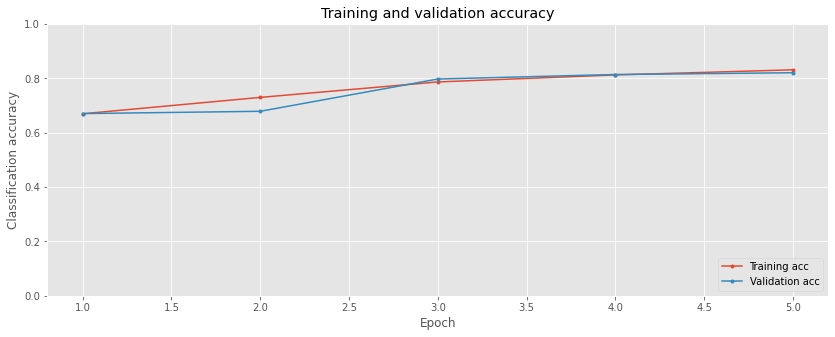

In [33]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [34]:
# Retrieve the embedding layer's weights from the trained model

weights = model.layers[1].get_weights()[0]

In [36]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

out_v = io.open(path.join('data', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('data', 'meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [2]:
# Create a SimpleRNN layer and test it

simplernn_layer = tf.keras.layers.SimpleRNN(units=16)

In [4]:
# Note that only the final cell output is returned

sequence = tf.constant([[[1., 1.], [2., 2.], [3., 3. ]]])
layer_output = simplernn_layer(sequence)
layer_output

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.8331887 , -0.83779645, -0.08416945,  0.90193444, -0.5953448 ,
         0.45546216,  0.93319404, -0.9761594 ,  0.04888319,  0.9606659 ,
        -0.42386228, -0.6647569 ,  0.8793807 , -0.99922603,  0.9104365 ,
         0.98481315]], dtype=float32)>

#### Load and transform the IMDB review sentiment dataset

In [2]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [3]:
# Load the dataset


(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

In [4]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [5]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

#### Create a recurrent neural network model

In [6]:
# Get the maximum index value

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [7]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_index_value+1,
                              output_dim=embedding_dim,
                              mask_zero=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#### Compile and fit the model

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 162,145
Trainable params: 162,145
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile the model with binary cross-entropy loss

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [10]:
len(x_train)

25000

In [15]:
# Fit the model and save its training history

train_steps = len(x_train) // 64

history = model.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_test, y_test), 
                    validation_batch_size=64, validation_steps=train_steps, steps_per_epoch=train_steps)

Epoch 1/3
390/390 [==============================] - 949s 2s/step - loss: 0.4413 - accuracy: 0.8130 - val_loss: 0.4236 - val_accuracy: 0.8094
Epoch 2/3
390/390 [==============================] - 957s 2s/step - loss: 0.2654 - accuracy: 0.9020 - val_loss: 0.3116 - val_accuracy: 0.8705
Epoch 3/3
390/390 [==============================] - 970s 2s/step - loss: 0.1983 - accuracy: 0.9292 - val_loss: 0.3201 - val_accuracy: 0.8698


#### Plot learning curves

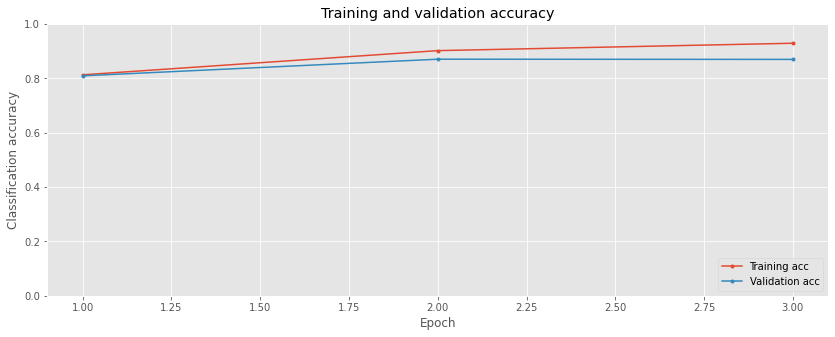

In [16]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [17]:
# View the first test data example sentence
# (invert the word index)

inv_imdb_word_index = {value: key for key, value in imdb_word_index.items()}
[inv_imdb_word_index[index] for index in x_test[0] if index > 2]

['please',
 'give',
 'this',
 'one',
 'a',
 'miss',
 'br',
 'br',
 'and',
 'the',
 'rest',
 'of',
 'the',
 'cast',
 'rendered',
 'terrible',
 'performances',
 'the',
 'show',
 'is',
 'flat',
 'flat',
 'flat',
 'br',
 'br',
 'i',
 "don't",
 'know',
 'how',
 'michael',
 'madison',
 'could',
 'have',
 'allowed',
 'this',
 'one',
 'on',
 'his',
 'plate',
 'he',
 'almost',
 'seemed',
 'to',
 'know',
 'this',
 "wasn't",
 'going',
 'to',
 'work',
 'out',
 'and',
 'his',
 'performance',
 'was',
 'quite',
 'so',
 'all',
 'you',
 'madison',
 'fans',
 'give',
 'this',
 'a',
 'miss']

In [20]:
# Get the model prediction using model.predict()

model.predict(x_test[None, 5, :])

array([[0.84644634]], dtype=float32)

In [21]:
# Get the corresponding label

y_test[5]

1

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [2]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [4]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset(num_words=5000,
                                                                maxlen=250)

In [5]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [6]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index(num_words=5000)

#### Build stacked and bidirectional recurrent models

In [7]:
# Get the maximum index value and specify an embedding dimension

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [8]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim,
                              mask_zero=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [14]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim,
                     mask_zero=True),
    layers.Bidirectional(layer = layers.LSTM(units=8), merge_mode='sum',
                         backward_layer=layers.GRU(units=8, go_backwards=True)),
    layers.Dense(units=1, activation='sigmoid')
])


In [16]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, 
                     mask_zero=True),
    layers.Bidirectional(layer=layers.LSTM(units=8, return_sequences=True), 
                         merge_mode='concat'),
    layers.GRU(units=8, return_sequences=False),
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          80016     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 16)          1600      
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 82,249
Trainable params: 82,249
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the model

In [17]:
# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model, saving its history

train_steps = len(x_train) // 64

history = model.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_test, y_test), 
                    validation_batch_size=64, validation_steps=train_steps, steps_per_epoch=train_steps)

Epoch 1/3
390/390 [==============================] - 231s 592ms/step - loss: 0.4296 - accuracy: 0.7901 - val_loss: 0.3210 - val_accuracy: 0.8694
Epoch 2/3
390/390 [==============================] - 225s 576ms/step - loss: 0.2500 - accuracy: 0.9032 - val_loss: 0.2652 - val_accuracy: 0.8945
Epoch 3/3
390/390 [==============================] - 224s 575ms/step - loss: 0.2026 - accuracy: 0.9256 - val_loss: 0.2741 - val_accuracy: 0.8896


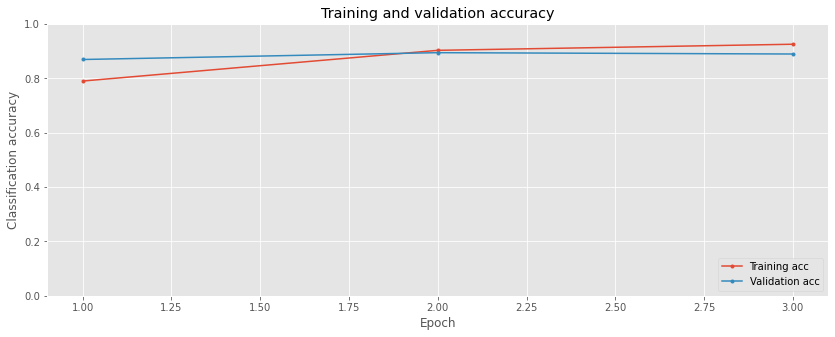

In [19]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);